In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('nycmeas.dat', sep='\s+', header=None, names=['Year', 'Cases'])
time = df['Year'].values
cases = df['Cases'].values
plt.figure(figsize=(6, 3))
plt.plot(time, cases/1000, color='black', linewidth=0.8, label='Observed Cases')
plt.xlim(time[0], time[-1])
plt.tight_layout()
plt.show()
plt.savefig("Fig_Measles.pdf", dpi=300) 

In [ ]:
from numba import jit
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors


@jit(nopython=True, fastmath=True)
def compute_errors_numba(neighbor_clouds, max_iter=50, eps=1e-5):
    n_samples, k, dim = neighbor_clouds.shape
    errors = np.empty(n_samples, dtype=np.float64)

    for i in range(n_samples):
        cloud = neighbor_clouds[i]

        y = np.zeros(dim)
        for d in range(dim):
            s = 0.0
            for j in range(k):
                s += cloud[j, d]
            y[d] = s / k

        for _ in range(max_iter):
            sum_weights = 0.0
            y_next = np.zeros(dim)
            all_non_zero = True

            for j in range(k):
                dist_sq = 0.0
                for d in range(dim):
                    diff = cloud[j, d] - y[d]
                    dist_sq += diff * diff
                dist = np.sqrt(dist_sq)

                if dist < 1e-10:
                    all_non_zero = False
                    for d in range(dim):
                        y[d] = cloud[j, d]
                    break

                w = 1.0 / dist
                sum_weights += w
                for d in range(dim):
                    y_next[d] += cloud[j, d] * w

            if not all_non_zero:
                break

            diff_norm_sq = 0.0
            for d in range(dim):
                y_next[d] /= sum_weights
                diff = y[d] - y_next[d]
                diff_norm_sq += diff * diff
                y[d] = y_next[d]

            if np.sqrt(diff_norm_sq) < eps:
                break

        total_dist = 0.0
        for j in range(k):
            dist_sq = 0.0
            for d in range(dim):
                diff = cloud[j, d] - y[d]
                dist_sq += diff * diff
            total_dist += np.sqrt(dist_sq)

        errors[i] = total_dist / k

    return errors


def time_delay_embedding(x, m, tau):
    x = np.asarray(x, dtype=np.float64)
    N = x.shape[0]
    L = N - (m - 1) * tau
    Z = np.empty((L, m), dtype=np.float64)
    for j in range(m):
        Z[:, j] = x[j * tau : j * tau + L]
    return Z


def estimate_intrinsic_stochasticity(
    embedding_data,
    pushforward,
    k=50,
    n_samples=5000,
    random_state=0,
    theiler_w=0,
    buffer_mult=6,
):
    data_norm = RobustScaler().fit_transform(np.asarray(embedding_data, dtype=np.float64))

    T = data_norm.shape[0]
    max_start = T - pushforward

    X_curr = data_norm[:max_start]
    Y_fut = data_norm[pushforward:]

    rng = np.random.default_rng(random_state)
    n_q = int(min(n_samples, max_start))
    query_idx = rng.choice(max_start, size=n_q, replace=False)

    k_query = int(min(max_start, max(k * buffer_mult, k + 2 * theiler_w + 5)))
    nbrs = NearestNeighbors(n_neighbors=k_query, algorithm="auto", n_jobs=-1).fit(X_curr)
    dist_raw, idx_raw = nbrs.kneighbors(X_curr[query_idx])

    nn_idx = np.empty((n_q, k), dtype=np.int64)

    for r in range(n_q):
        q = int(query_idx[r])
        cand = idx_raw[r]

        picked = 0
        for j in range(k_query):
            t = int(cand[j])
            if t == q:
                continue
            if theiler_w > 0 and (abs(t - q) <= theiler_w):
                continue
            nn_idx[r, picked] = t
            picked += 1
            if picked == k:
                break

    neighbor_clouds = Y_fut[nn_idx]
    local_errors = compute_errors_numba(neighbor_clouds)
    return float(np.mean(local_errors))

In [16]:
df = pd.read_csv("nycmeas.dat", sep=r"\s+", header=None, names=["Year", "Cases"], engine="python")
cases_raw = df["Cases"].to_numpy(dtype=np.float64)
cases_log = np.log1p(cases_raw)

k = 20
n_samples = 3000
buffer_mult = 10
random_state = 0

m_list = [4,5,6]
tau_list = [1, 2, 4, 8, 10]
pushforward_list = [1, 6, 12, 24, 36]

rows = []
for m in m_list:
    for tau in tau_list:
        Z_raw = time_delay_embedding(cases_raw, m=m, tau=tau)
        Z_log = time_delay_embedding(cases_log, m=m, tau=tau)
        for n in pushforward_list:
            theiler_w = int(max(n, (m - 1) * tau))

            E_raw = estimate_intrinsic_stochasticity(
                embedding_data=Z_raw,
                pushforward=n,
                k=k,
                n_samples=min(n_samples, Z_raw.shape[0] - n),
                random_state=random_state,
                theiler_w=theiler_w,
                buffer_mult=buffer_mult,
            )
            E_log = estimate_intrinsic_stochasticity(
                embedding_data=Z_log,
                pushforward=n,
                k=k,
                n_samples=min(n_samples, Z_log.shape[0] - n),
                random_state=random_state,
                theiler_w=theiler_w,
                buffer_mult=buffer_mult,
            )

            rows.append((m, tau, n, theiler_w, E_raw, E_log, E_raw - E_log, 100.0 * (E_raw - E_log) / E_raw))

out = pd.DataFrame(
    rows,
    columns=["m", "tau", "pushforward", "theiler_w", "E_raw", "E_log", "delta_E", "delta_E_pct"],
).sort_values(["pushforward", "delta_E_pct"], ascending=[True, False])

print(out.to_string(index=False))
out.to_csv("measles_Estar_raw_vs_log_grid.csv", index=False)

 m  tau  pushforward  theiler_w    E_raw    E_log  delta_E  delta_E_pct
 6    4            1         20 1.473974 0.591490 0.882484    59.871077
 6   10            1         50 1.782661 0.721825 1.060835    59.508554
 5   10            1         40 1.449723 0.604079 0.845644    58.331389
 5    4            1         16 1.251904 0.532421 0.719483    57.471090
 6    8            1         40 1.679431 0.714833 0.964598    57.436028
 5    8            1         32 1.488508 0.643900 0.844608    56.741909
 4    8            1         24 1.261409 0.557983 0.703427    55.765154
 4   10            1         30 1.160425 0.516725 0.643700    55.471053
 4    4            1         12 1.043398 0.466760 0.576637    55.265349
 6    2            1         10 1.024295 0.532047 0.492248    48.057210
 4    2            1          6 0.732485 0.382663 0.349822    47.758286
 5    2            1          8 0.878410 0.461983 0.416427    47.406886
 4    1            1          3 0.568655 0.299997 0.268658    47

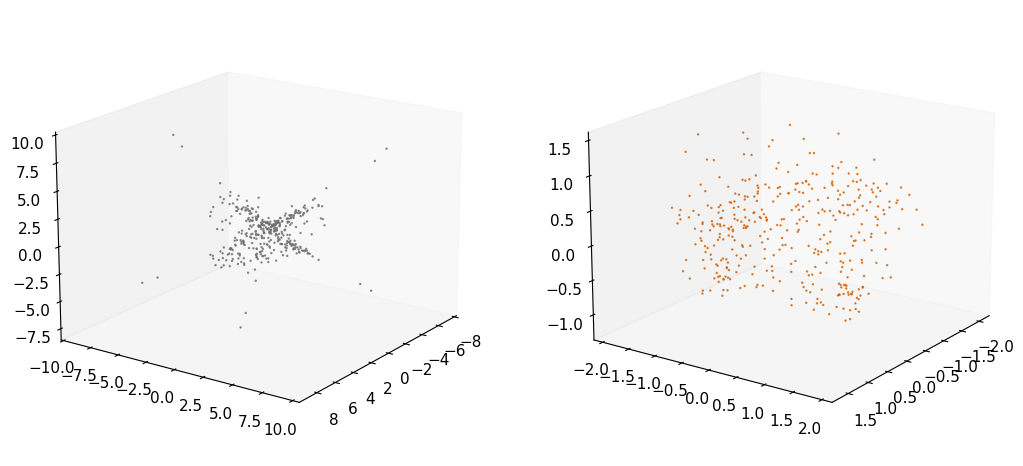

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Zr = RobustScaler().fit_transform(Z_raw)
Zl = RobustScaler().fit_transform(Z_log)

raw_color = "#6e6e6e"
log_color = "#D55E00"


pca = PCA(n_components=3)
Pr = pca.fit_transform(Zr)
Pl = pca.transform(Zl)

fig = plt.figure(figsize=(11, 4.8))
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")

ax1.scatter(Pr[:,0], Pr[:,1], Pr[:,2], s=0.5, alpha=0.8, c=raw_color)
ax2.scatter(Pl[:,0], Pl[:,1], Pl[:,2], s=0.5, alpha=0.8, c=log_color)

ax1.grid(False)
ax2.grid(False)

ax1.view_init(elev=18, azim=35)
ax2.view_init(elev=18, azim=35)

plt.tight_layout()
plt.savefig("raw_vs_log_pca3d.pdf", dpi=300)
plt.show()


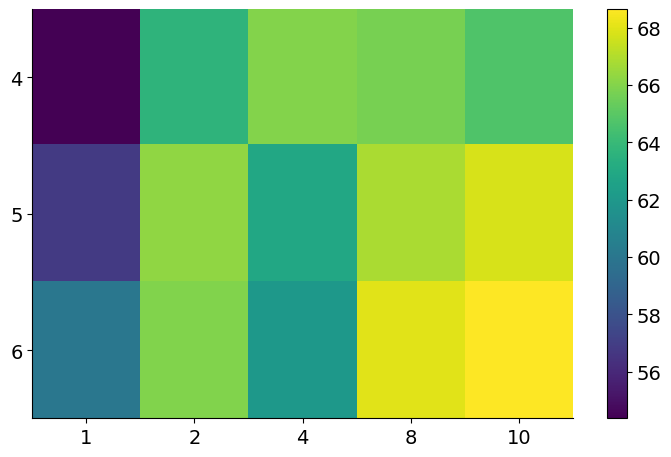

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("measles_Estar_raw_vs_log_grid.csv")

plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "legend.fontsize": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

n0 = 12  
sub = df[df["pushforward"] == n0].copy()

m_vals = sorted(sub["m"].unique())
tau_vals = sorted(sub["tau"].unique())

pivot = sub.pivot_table(index="m", columns="tau", values="delta_E_pct", aggfunc="mean")
pivot = pivot.reindex(index=m_vals, columns=tau_vals)

fig, ax = plt.subplots(figsize=(7.4, 4.8))
im = ax.imshow(pivot.values, aspect="auto")

ax.set_xticks(np.arange(len(tau_vals)))
ax.set_xticklabels([str(t) for t in tau_vals])
ax.set_yticks(np.arange(len(m_vals)))
ax.set_yticklabels([str(m) for m in m_vals])

cbar = fig.colorbar(im, ax=ax)

fig.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("measles_Estar_raw_vs_log_grid.csv")

plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.fontsize": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

pushes = sorted(df["pushforward"].unique())
data = [df.loc[df["pushforward"] == p, "delta_E_pct"].values for p in pushes]

fig, ax = plt.subplots(figsize=(7.2, 4.2))
ax.boxplot(data, labels=[str(p) for p in pushes], showfliers=False)

fig.tight_layout()
plt.savefig("Fig_measles_log_reduction_boxplot.pdf", dpi=300)
plt.show()